<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>    

# Group Number:37
# Student 1: Jiong Li | 1533312
# Student 2: Peter Elmers | 1734350
# Student 3: P.T.C.M. Tholhuijsen | 1237447

In [2]:
import requests
import io
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### Training data set


For Assignment 1 you need to use a specific data set prepared using images from the [Omniglot dataset](https://github.com/brendenlake/omniglot). The provided training data set contains images of handwritten characters of size (28,28). 



For training data, the dataset contains 10000 sets of 6 images each. Each set consists of 5 support images and 1 query image. In each set, the first five columns are support images and the last one is a query image.

For training labels, the dataset contains 10000 sets of 5 binary flags for support images. 1 indicates the same character is given in the query image and 0 means not. For example, a label [1,0,0,1,1] means the support images with index 0,3,4 are the same character of query image.

 
 
The following cell provides code that loads the data from hardcoded URLs.You can use the code in this cell to load the dataset or download the data set from the given URLs to your local drive (or your Google drive) and modify the code to load the data from another location. 




In [3]:
def load_numpy_arr_from_url(url):
    """
    Loads a numpy array from surfdrive. 
    
    Input:
    url: Download link of dataset 
    
    Outputs:
    dataset: numpy array with input features or labels
    """
    
    response = requests.get(url)
    response.raise_for_status()

    return np.load(io.BytesIO(response.content)) 
    
    
    
#Downloading may take a while..
train_data = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/4OXkVie05NPjRKK/download')
train_label = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/oMLFw60zpFX82ua/download')

print(f"train_data shape: {train_data.shape}")
print(f"train_label shape: {train_label.shape}\n")

train_data shape: (10000, 6, 28, 28)
train_label shape: (10000, 5)



Now, we plot the first 5 cases in the training dataset. The last column corresponds with the query images of each task. All other images are support images. The image enclosed in a red box denotes the target image that your model should be able to recognize as the same class as the query image. 

In [4]:
def plot_case(caseID,train_data,labels):
    """
    Plots a single sample of the query dataset
    
    Inputs
    caseID: Integer between 0 and 99, each corresponding to a single sample in the query dataset 
    """
    

    support_set,queries = np.split(train_data, [5], axis=1)
    
    f, axes = plt.subplots(1, 6, figsize=(20,5))

    # plot anchor image
    axes[5].imshow(queries[caseID, 0])
    axes[5].set_title(f"Query image case {caseID}", fontsize=15)

    # show all test images images 
    [ax.imshow(support_set[caseID, i]) for i, ax in enumerate(axes[0:-1])]


    # Add the patch to the Axes
    for ind in np.where(labels[caseID]==True)[0]:
        axes[ind].add_patch(Rectangle((0,0),27,27,linewidth=2, edgecolor='r',facecolor='none'))


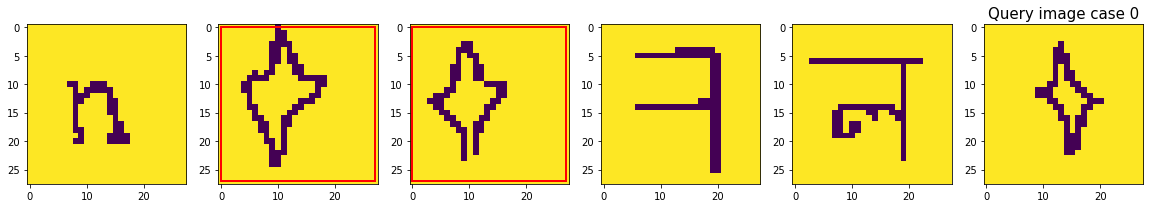

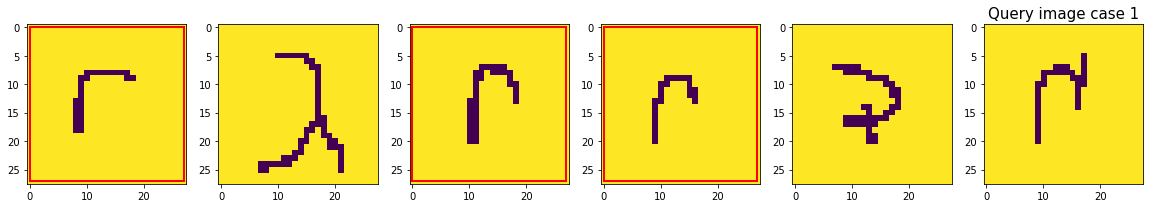

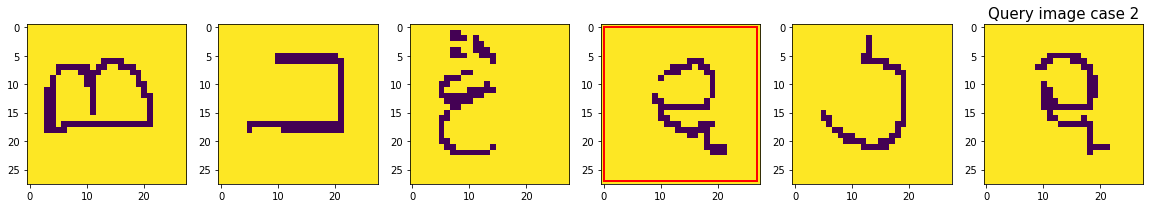

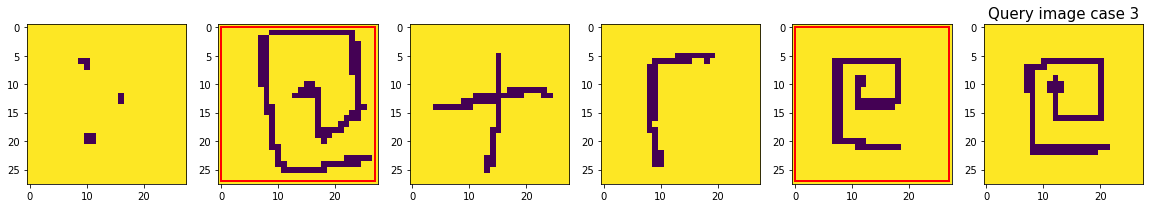

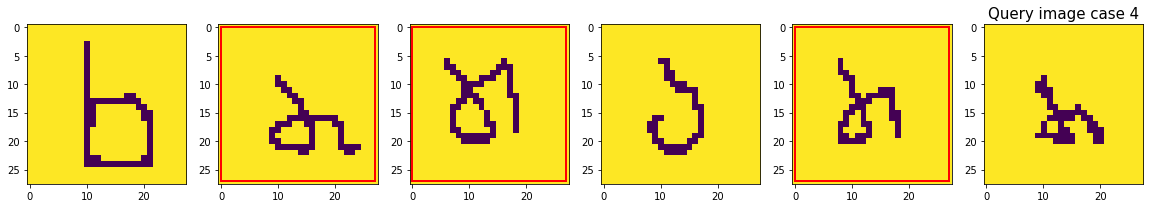

In [5]:
[plot_case(caseID,train_data,train_label) for caseID in range(5)] ;

### Query data set

For this task you need to use the following query data set. The dataset contains 1000 sets of 6 images each. The images are also of hand written characters, however these characters are not present in the training data set. The characters in the query data set all come from the Greek alphabet that is not part of the set of alphabets in the training data. 


In [6]:
    
#Downloading may take a while..
test_data = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/06c34QVUr69CxWY/download')
test_label = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/LQIH1CW7lfDXevk/download')

print(f"test_data shape: {test_data.shape}")
print(f"test_label shape: {test_label.shape}\n")

test_data shape: (1000, 6, 28, 28)
test_label shape: (1000, 5)



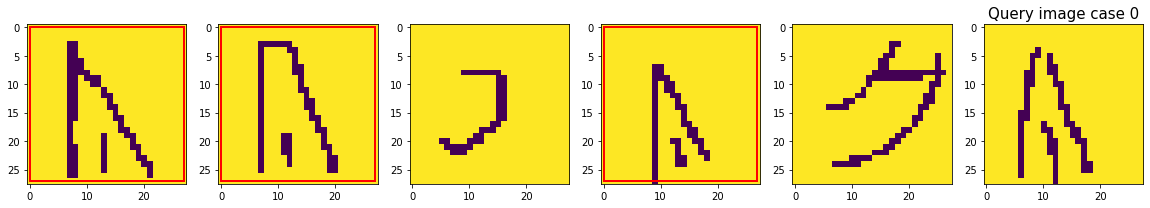

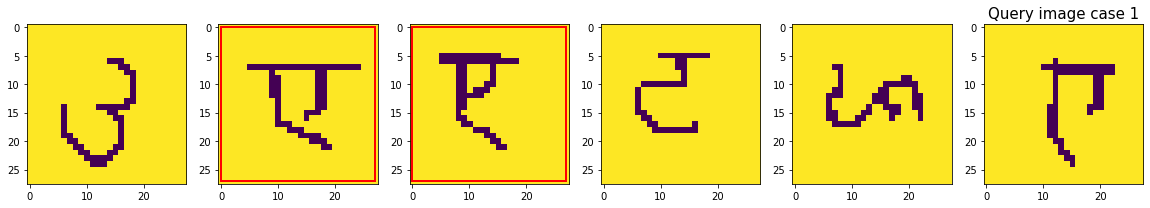

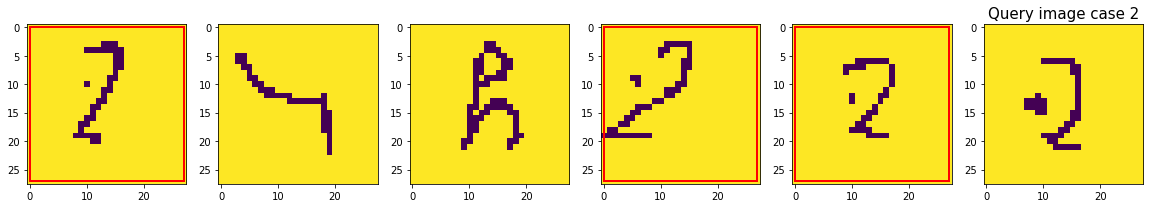

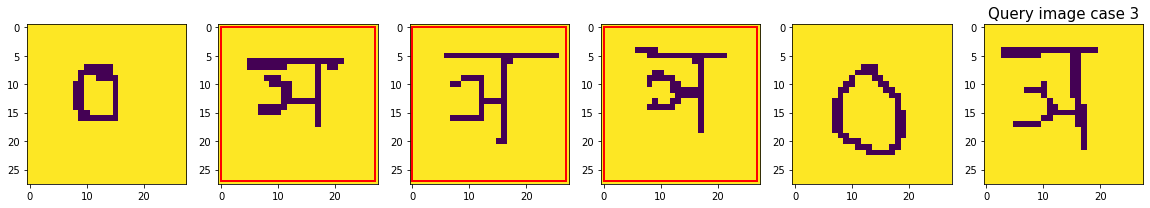

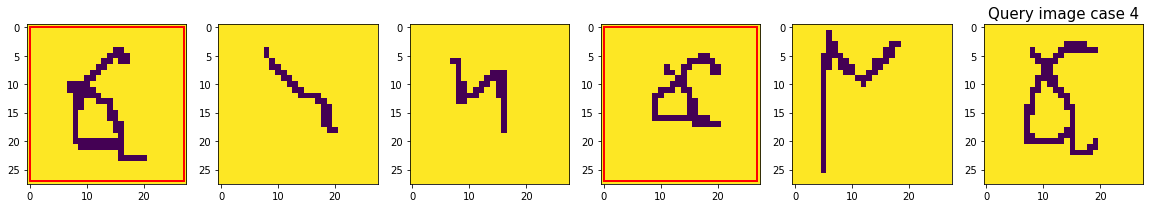

In [7]:
[plot_case(caseID,test_data,test_label) for caseID in range(5)] ;

### Build pytorch dataset and dataload

In [8]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader,TensorDataset
import numpy as np
from PIL import Image

class MyDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = torch.FloatTensor(data)
        self.targets = torch.LongTensor(targets)
        self.transform = transform

        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        return x, y
    
    def __len__(self):
        return len(self.data)

In [9]:
from sklearn.model_selection import train_test_split
train_data, validation_data, train_label, validation_label = train_test_split(train_data, train_label, test_size=0.2)

In [10]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(0, 1)])
train_dataset=MyDataset(train_data,train_label, transform)
validation_dataset=MyDataset(validation_data,validation_label, transform)
test_dataset=MyDataset(test_data,test_label, transform)

In [11]:
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=10)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=10)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10)

In [12]:
# What is the data loader output shape?
x_example, y_example = next(iter(torch.utils.data.DataLoader(train_dataset, batch_size=10)))
x_example.shape, y_example.shape

(torch.Size([10, 6, 28, 28]), torch.Size([10, 5]))

In [13]:
import random
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

# Fitting/Training the model
def random_rotate(img):
    angle = random.choice([0, 90, 180, 270])
    return TF.rotate(img, angle)

def make_triplets(imgs, yb):
    '''
    For each tuple of imgs, create triples of (anchor, positive, negative).
    One triple for each positive, negatives are chosen randomly.
    '''
    # N = batch size
    N = imgs.shape[0]
    anchors = []
    positives = []
    negatives = []
    # for each batch, get pos_yb and neg_yb. then for each positive, take a random negative
    for n in range(N):
        pos_yb = (yb[n, :] == 1).nonzero()
        neg_yb = (yb[n, :] == 0).nonzero()
        for pos_idx in pos_yb:
            # TODO: add data augmentation? by rotation
            anchors.append(imgs[n, 0].unsqueeze(0))
            # add 1 to the index because query is the first one
            positives.append(imgs[n, 1 + pos_idx])
            negatives.append(imgs[n, 1 + random.choice(neg_yb)])
            
    # Return N*r anchors, positives, negatives
    return [torch.cat(imgs) for imgs in [anchors, positives, negatives]]

def fit(epochs, loss_func, model, train_loader, val_loader, opt):
    threshold = 0.5
    loss_graph = []
    for epoch in range(epochs):
        model = model.train()
        print(f'Epoch {epoch + 1}')
        
        losses = []
        for imgs, yb in tqdm(train_loader, desc="Training"):
            opt.zero_grad()

            anchor, positive, negative = make_triplets(imgs, yb)
            # Then apply model to each of the three and use triplet loss: https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginLoss.html(a, p, n)
            # http://www.bmva.org/bmvc/2016/papers/paper119/paper119.pdf
            if torch.cuda.is_available():
                anchor, positive, negative = [v.cuda() for v in [anchor, positive, negative]]
            
            anchor, positive, negative = [model(v) for v in [anchor, positive, negative]]
            
            loss = loss_func(anchor, positive, negative)

            # Backward and optimize
            loss.backward()
            opt.step()

            # Record data
            losses.append(loss.item() / anchor.shape[0])

        loss_graph.append(sum(losses) / len(train_loader))
        print(f'Average loss: {loss_graph[-1]}')

        print('Train accuracy:' f'{(threshold, test(model, train_loader, threshold))}')
        print('Validation accuracy:' f'{(threshold, test(model, val_loader, threshold))}')
        # threshold_range = list(torch.linspace(0, 1, 5))
        # print(
            # 'Validation accuracy by threshold:'
            # f'{[(t.item(), test(model, val_loader, t)) for t in tqdm(threshold_range, desc="Validating")]}')

    plt.plot(loss_graph)
    plt.title("training loss")
    plt.xlabel("epoch number")
    plt.ylabel("loss value")


def test(model, test_loader, threshold=0.5):
    model = model.eval()
    running_acc = 0.0
    with torch.no_grad():
        for imgs, yb in test_loader:
            if torch.cuda.is_available():
                imgs = imgs.cuda()
                yb = yb.cuda()

            # Embed each img
            query = model(imgs[:, 0])
            supports = []
            for col in range(1, imgs.shape[1]):
                embed = model(imgs[:, col])
                supports.append(embed)

            # Calculate euclidean/cosine distance from query to each support
            cos = nn.CosineSimilarity()
            # distances = torch.stack([((query - sup)**2).sum(axis=1).sqrt() for sup in supports]).T
            distances = torch.stack([0.5 - (cos(query, sup) / 2.) for sup in supports]).T
            # Classify based on given threshold: if support is closer than threshold, it is the same
            # softmax of euclidean distances: https://arxiv.org/pdf/1703.05175.pdf
            # ratio measure via softmax: https://arxiv.org/pdf/1412.6622.pdf
            preds = (distances < threshold).float()
            # Accuracy = percentage of correctly classified support images
            running_acc += ((preds == yb).sum() / yb.shape[0] / yb.shape[1]).item()
            
        test_acc = running_acc / len(test_loader)
        
        return test_acc

# TODO: show a couple examples of make_triplets

In [14]:
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F

class ZeroModel(nn.Module):
    def __init__(self):
        super(ZeroModel, self).__init__()

    def forward(self, images):
        return torch.zeros((images.shape[0], images.shape[1]))

class RandomModel(nn.Module):
    def __init__(self):
        super(RandomModel, self).__init__()

    def forward(self, images):
        return torch.randn((images.shape[0], images.shape[1]))

In [25]:
# The model

class Flatten(nn.Module):
    def forward(self, x):
        N = x.shape[0]
        return x.view(N, -1)

class Model(nn.Module):
    # Examples: https://github.com/MSiam/Few-Shot-Learning
    def __init__(self):
        super(Model, self).__init__()
        channels = [1, 16, 64, 128]
        embedding_length = 32

        # Image is N x 28 x 28, N = batch size
        self.embed = nn.Sequential(
            nn.Conv2d(channels[0], channels[1], 7, padding=3),
            nn.BatchNorm2d(channels[1]),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(channels[1], channels[2], 3, padding=1),
            nn.BatchNorm2d(channels[2]),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(channels[2], channels[3], 3, padding=1),
            nn.BatchNorm2d(channels[3]),
            nn.ReLU(),
            Flatten(),
            nn.Linear(7 * 7 * channels[3], embedding_length)
        )

    def forward(self, x):
        if len(x.shape) == 3:
            x = x.unsqueeze(1)
        x = self.embed(x)
        return x

model = Model()
def count_parameters(model):
    temp = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'The model architecture:\n\n', model)
    print(f'\nThe model has {temp:,} trainable parameters')
    
count_parameters(model)

The model architecture:

 Model(
  (embed): Sequential(
    (0): Conv2d(1, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): ReLU()
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Flatten()
    (12): Linear(in_features=6272, out_features=32, bias=True)
  )
)

The model has 285,088 trainable parameters


/var/folders/bj/xq0r65c15zscywj6dg01l4rr0000gn/T/ipykernel_84978/1979104940.py:40: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  temp = sum(p.numel() for p in model.parameters() if p.requires_grad)


In [16]:
# Baseline: a model that always predicts 0 (different category for all support images)
print('Zero model stats')
print(f"Train accuracy: {test(ZeroModel(), train_loader, 0):.4f}")
print(f"Validation accuracy: {test(ZeroModel(), validation_loader, 0):.4f}")
print(f"Test accuracy: {test(ZeroModel(), test_loader, 0):.4f}")

print('Random model stats')
print(f"Train accuracy: {test(RandomModel(), train_loader, 0.5):.4f}")
print(f"Validation accuracy: {test(RandomModel(), validation_loader, 0.5):.4f}")
print(f"Test accuracy: {test(RandomModel(), test_loader, 0.5):.4f}")

Zero model stats
Train accuracy: 0.5996
Validation accuracy: 0.6024
Test accuracy: 0.6114
Random model stats
Train accuracy: 0.5026
Validation accuracy: 0.5008
Test accuracy: 0.5044


Epoch 1


Training: 100%|██████████| 800/800 [00:26<00:00, 30.75it/s]


Average loss: 0.010716655932443192
Train accuracy:(0.5, 0.7571249960362911)
Validation accuracy:(0.5, 0.4949000008404255)
Epoch 2


Training: 100%|██████████| 800/800 [00:26<00:00, 29.71it/s]


Average loss: 0.010429409773928726
Train accuracy:(0.5, 0.761324995085597)
Validation accuracy:(0.5, 0.49720000192523)
Epoch 3


Training: 100%|██████████| 800/800 [00:26<00:00, 30.71it/s]


Average loss: 0.010086600203689471
Train accuracy:(0.5, 0.7590999970585108)
Validation accuracy:(0.5, 0.4875000016391277)
Epoch 4


Training: 100%|██████████| 800/800 [00:26<00:00, 30.59it/s]


Average loss: 0.009532629654389228
Train accuracy:(0.5, 0.7588999954611063)
Validation accuracy:(0.5, 0.4930000001192093)
Epoch 5


Training: 100%|██████████| 800/800 [00:26<00:00, 30.59it/s]


Average loss: 0.009240309518356742
Train accuracy:(0.5, 0.7578249961137772)
Validation accuracy:(0.5, 0.491500001847744)
Epoch 6


Training: 100%|██████████| 800/800 [00:25<00:00, 30.80it/s]


Average loss: 0.009055749091473352
Train accuracy:(0.5, 0.765424994379282)
Validation accuracy:(0.5, 0.4954000027477741)
Epoch 7


Training: 100%|██████████| 800/800 [00:26<00:00, 29.64it/s]


Average loss: 0.008548558486005317
Train accuracy:(0.5, 0.7722999950498343)
Validation accuracy:(0.5, 0.49690000161528586)
Epoch 8


Training: 100%|██████████| 800/800 [00:27<00:00, 28.92it/s]


Average loss: 0.008413293560895138
Train accuracy:(0.5, 0.7672749949991703)
Validation accuracy:(0.5, 0.4912000007927418)
Epoch 9


Training: 100%|██████████| 800/800 [00:27<00:00, 29.40it/s]


Average loss: 0.007935078525076713
Train accuracy:(0.5, 0.7448249957710504)
Validation accuracy:(0.5, 0.4861000023782253)
Epoch 10


Training: 100%|██████████| 800/800 [00:26<00:00, 29.83it/s]


Average loss: 0.007832683894191863
Train accuracy:(0.5, 0.7538499953225255)
Validation accuracy:(0.5, 0.4907000009715557)


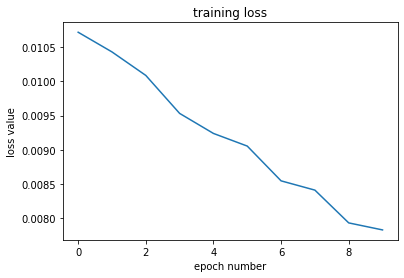

In [38]:
# model = Model()

threshold = 1
loss_func = nn.TripletMarginWithDistanceLoss(
    distance_function=lambda x,y: 1. - F.cosine_similarity(x, y), margin=threshold)

if torch.cuda.is_available():
    model = model.cuda()
    loss_func = loss_func.cuda()

# The optimizer
from torch.optim import AdamW, SGD

# optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=0.005)
optimizer = SGD(model.parameters(), lr=1e-3, momentum=0.9)

epochs = 10
fit(epochs, loss_func, model, train_loader, validation_loader, optimizer)

100%|██████████| 10/10 [01:48<00:00, 10.89s/it]


Text(0, 0.5, 'training accuracy')

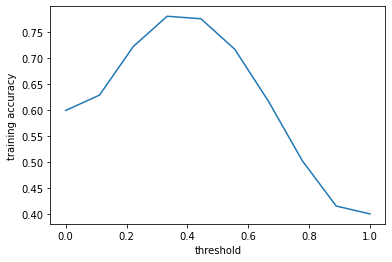

In [39]:
# Search for a good threshold on the validation set
threshold_range = list(torch.linspace(0, 1, 10))
acc_graph = [test(model, train_loader, t) for t in tqdm(threshold_range)]
plt.plot(threshold_range, acc_graph)
plt.xlabel("threshold")
plt.ylabel("training accuracy")

100%|██████████| 20/20 [00:47<00:00,  2.36s/it]


Text(0, 0.5, 'validation accuracy')

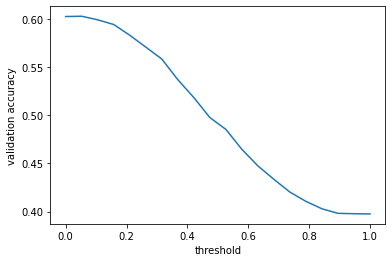

In [40]:
# Search for a good threshold on the validation set
threshold_range = list(torch.linspace(0, 1, 20))
acc_graph = [test(model, validation_loader, t) for t in tqdm(threshold_range)]
plt.plot(threshold_range, acc_graph)
plt.xlabel("threshold")
plt.ylabel("validation accuracy")

In [31]:
best_threshold = threshold_range[max(range(len(threshold_range)), key=lambda i: acc_graph[i])]
print(f'Threshold is {best_threshold}')
acc = test(model, test_loader, best_threshold)
print(f'Accuracy is {acc}')

Threshold is 0.1111111119389534
Accuracy is 0.6094000029563904
